# World Models

### 1. V-Model

### 2. M-Model

### 3. C-Model



In [1]:
import pyglet 

window = pyglet.window.Window()

pyglet.app.run()

In [1]:
import gym
from gym.spaces import Box
import numpy as np
print(gym.__version__)
try:
    import cv2
except ImportError:
    cv2 = None
    
#from pyvirtualdisplay import Display
#_display = Display(visible=False, size=(1400, 900))
#_ = _display.start()

0.17.3


In [2]:
# bring observation in desired shape and scale observation between 0 and 1
class MaxAndSkipEnv(gym.Wrapper):
    def __init__(self, env, skip=4):
        """Return only every `skip`-th frame"""
        gym.Wrapper.__init__(self, env)
        # most recent raw observations (for max pooling across time steps)
        self._obs_buffer = np.zeros((2,)+env.observation_space.shape, dtype=np.uint8)
        self._skip       = skip

    def step(self, action):
        """Repeat action, sum reward, and max over last observations."""
        total_reward = 0.0
        done = None
        for i in range(self._skip):
            obs, reward, done, info = self.env.step(action)
            if i == self._skip - 2: self._obs_buffer[0] = obs
            if i == self._skip - 1: self._obs_buffer[1] = obs
            total_reward += reward
            if done:
                break
        # Note that the observation on the done=True frame
        # doesn't matter
        max_frame = self._obs_buffer.max(axis=0)

        return max_frame, total_reward, done, info

    def reset(self, **kwargs):
        return self.env.reset(**kwargs)
class ObservationWrapper(gym.Wrapper):
    def __init__(self, env, image_size=(64,64,3), scale_obs=True):
        super().__init__(env)
        self.shape = image_size
        self.screen_size = image_size[0]
        self.scale_obs = scale_obs
        _low, _high, _obs_dtype = (0, 255, np.uint8) if not scale_obs else (0, 1, np.float32)
        self.observation_space = Box(low=_low, high=_high, shape=image_size, dtype=_obs_dtype)
        
    def step(self, action):
        obs, reward, done, info = self.env.step(action)
        return self._get_obs(obs), reward, done, info
    
    def reset(self):
        obs = self.env.reset()
        return self._get_obs(obs)
        
    
    def _get_obs(self, obs):

        obs = cv2.resize(obs, (self.screen_size, self.screen_size))#, interpolation=cv2.INTER_AREA)

        if self.scale_obs:
            obs = np.asarray(obs, dtype=np.float32) / 255.0
        return obs
    
class PytorchWrapper(gym.Wrapper):
    def __init__(self, env):
        super().__init__(env)
        
    def step(self, action):
        obs, reward, done, info = self.env.step(action)
        obs = torch.from_numpy(obs).reshape((3,64,64)).unsqueeze(0)
        return obs, reward, done, info
    
    def reset(self):
        obs = self.env.reset()
        obs = torch.from_numpy(obs).reshape((3,64,64)).unsqueeze(0)
        return obs
        
        

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.utils import clip_grad_norm_
from torch.utils.data import TensorDataset, DataLoader
from torch.distributions import Normal

import matplotlib.pyplot as plt

# V-Model

In [4]:
class VAE():
    def __init__(self, state_size, latent_size_N=32, device="cpu"):
              
        self.encoder = Encoder(state_size, latent_size_N).to(device)
        self.decoder = Decoder(state_size, latent_size_N).to(device)
        self.device = device
        
        self.params = list(self.encoder.parameters()) + list(self.decoder.parameters())
        self.optimizer = optim.Adam(params=self.params, lr=0.001)
        #self.optimizer_decoder = optim.Adam(params=self.decoder.parameters(), lr=0.0001)
        
    def forward(self, image: torch.Tensor)-> torch.Tensor:
        
        assert image.shape == (image.shape[0] ,3, 64, 64), "Input Image as wrong shape!"
        mu, sig = self.encoder(image)
        encoded = self.sample(mu, sig)
        
        decoded = self.decoder(encoded)
        return decoded, (mu, sig)
    
    def encode_state(self, image: torch.Tensor)-> torch.Tensor:
        assert image.shape == (image.shape[0], 3, 64, 64), "Input Image as wrong shape!"
        (mu, logsig) = self.encoder(image)
        encoded = self.sample(mu, logsig)
        return encoded
    
    def sample(self, mu, logsig):
            
        #dist = Normal(mu, sig) 
        #latent_vector_z = dist.sample()
        
        # in the paper they had different sample methods this one and mu + sig *N(0,1)
        #latent_vector_z = mu + sig * torch.normal(torch.zeros(1), torch.ones(1)).to(device)
        
        sigma = logsig.exp()
        eps = torch.randn_like(sigma)     
        return eps.mul(sigma).add_(mu)
        
    def train(self, dataloader:DataLoader)-> torch.Tensor:
        losses = {"loss1": [], "loss2": []}
        for idx, sample in enumerate(dataloader):
            
            image_batch = sample[0].to(device)
            reconstructed, (mu, sig) = self.forward(image_batch)
            
            loss_1 = kl_loss(mu, sig)
            loss_2 = l2_dist_loss(reconstructed, image_batch)
            
            self.optimizer.zero_grad()
            loss = (loss_1 + loss_2).mean()
            
            loss.backward()
            #clip_grad_norm_(self.params, 10.)
            self.optimizer.step()
            losses["loss1"].append(loss_1.detach().cpu().numpy())
            losses["loss2"].append(loss_2.detach().cpu().numpy())
        return np.mean(losses["loss1"]),np.mean(losses["loss2"]) 
            
            

def kl_loss(mu: torch.Tensor, sig:torch.Tensor)-> torch.Tensor:
    #loss = - 0.5 * (1 + torch.log(sig).pow(2) - sig.pow(2) - mu.pow(2)).sum()
    loss = -0.5 * torch.sum(1 + 2 * sig - mu.pow(2) - (2 * sig).exp())
    return loss

def l2_dist_loss(prediction:torch.Tensor, target:torch.Tensor)-> torch.Tensor:
    #return - torch.dist(target,prediction, p=2)
    return F.mse_loss(prediction, target, size_average=False)
    #return F.binary_cross_entropy(prediction, target, size_average=False)
        
class Encoder(nn.Module):
    def __init__(self, state_size, latent_size_N=32):
        super(Encoder, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=4, stride=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2)
        self.output_mu = nn.Linear(1024, latent_size_N)
        self.output_sig = nn.Linear(1024, latent_size_N)
        #self.softplus = nn.Softplus() #use different activation?
        
    
    def forward(self, img):
        
        x = torch.relu(self.conv1(img))
        #print(x.shape)
        x = torch.relu(self.conv2(x))
        #print(x.shape)
        x = torch.relu(self.conv3(x))
        #print(x.shape)
        x = torch.relu(self.conv4(x))
        #print(x.shape)
        
        mu = self.output_mu(x.flatten(1)) #torch.tanh()
        log_sig = self.output_sig(x.flatten(1))#self.softplus()
        #sig = torch.sqrt(var)
                    
        return (mu, log_sig)

        
class Decoder(nn.Module):
    def __init__(self, state_size, latent_size_N=32):
        super(Decoder, self).__init__()
        
        self.in_linear = nn.Linear(32, 1024)
        self.deconv1 = nn.ConvTranspose2d(in_channels=1024, out_channels=128, kernel_size=5, stride=2)
        self.deconv2 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=5, stride=2)
        self.deconv3 = nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=6, stride=2)
        self.deconv4 = nn.ConvTranspose2d(in_channels=32, out_channels=3, kernel_size=6, stride=2)
        
    def forward(self, latent_vector):
        
        x = torch.relu(self.in_linear(latent_vector)).unsqueeze(-1).unsqueeze(-1)
        x = torch.relu(self.deconv1(x))
        #print(x.shape)
        x = torch.relu(self.deconv2(x))
        #print(x.shape)
        x = torch.relu(self.deconv3(x))
        #print(x.shape)
        x = torch.sigmoid(self.deconv4(x))
        #print(x.shape)
        return x

# Create Samples with random policy


In [5]:
env = gym.make("CarRacing-v0")
env = MaxAndSkipEnv(env)
env = ObservationWrapper(env, image_size=(64,64,3), scale_obs=True)
env = PytorchWrapper(env)
state_size = env.observation_space.shape
action_size = env.action_space.shape[0]

/home/sebastian/anaconda3/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [7]:
Episodes = 3
samples = {"states":[], "actions": [], "next_states": [], "rewards": [], "dones":[]}

for ep in range(Episodes):
    done=False
    state = env.reset()
    step_count = 0 ## First ~50 steps is zooming to start position. not needed for training
    while True:
        action = env.action_space.sample()
        next_state, reward, done, _ = env.step(action)
        step_count += 1
        
        if step_count > 50:
            samples["states"].append(state)
            samples["next_states"].append(next_state)
            samples["actions"].append(action)
            samples["rewards"].append(reward)
            samples["dones"].append(done)
        state = next_state
        if done:
            print("Ep: {} | Sample size: {}".format(ep, len(samples["states"])))
            break
    env.close()
        

Track generation: 1244..1558 -> 314-tiles track
Ep: 0 | Sample size: 200
Track generation: 999..1253 -> 254-tiles track
Ep: 1 | Sample size: 400
Track generation: 1116..1406 -> 290-tiles track
Ep: 2 | Sample size: 600


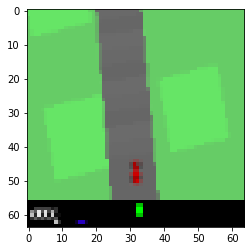

In [7]:
plt.imshow(samples["states"][4].squeeze().reshape(64,64,3))

# Create Dataset 

In [7]:
# Create Dataset of states
set = torch.cat(samples["states"], dim=0)
dataset = TensorDataset(set)
dataloader = DataLoader(dataset, batch_size=256, shuffle=True)

# Build V-Model

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = "cpu"
V_model = VAE(state_size=(3, 64, 64), device=device)
print("Using: {}".format(device))

Using: cuda:0


In [11]:
Epochs = 150
losses = {"loss1": [], "loss2": [], "loss": []}
for i in range(Epochs):
    loss1, loss2 = V_model.train(dataloader)
    print("\rEpoch: {} | kl_loss: {:.2f} | l2_loss: {:.2f} | combines loss: {:.2f}".format(i, loss1, loss2, loss1+loss2), end="", flush=True)
    if i % 10 == 0:
        print("\rEpoch: {} | kl_loss: {:.2f} | l2_loss: {:.2f} | combines loss: {:.2f}".format(i, loss1, loss2, loss1+loss2))
        
    losses["loss1"].append(loss1)    
    losses["loss2"].append(loss2)    
    losses["loss"].append(loss1+loss2)

Epoch: 0 | kl_loss: 71.90 | l2_loss: 169813.84 | combines loss: 169885.75
Epoch: 10 | kl_loss: 21.05 | l2_loss: 28028.80 | combines loss: 28049.84
Epoch: 20 | kl_loss: 32.07 | l2_loss: 25725.03 | combines loss: 25757.10
Epoch: 30 | kl_loss: 55.31 | l2_loss: 24758.92 | combines loss: 24814.22
Epoch: 40 | kl_loss: 696.14 | l2_loss: 20248.38 | combines loss: 20944.52
Epoch: 50 | kl_loss: 681.27 | l2_loss: 16865.11 | combines loss: 17546.38
Epoch: 60 | kl_loss: 836.19 | l2_loss: 14402.72 | combines loss: 15238.91
Epoch: 70 | kl_loss: 1080.46 | l2_loss: 12009.75 | combines loss: 13090.21
Epoch: 80 | kl_loss: 1121.50 | l2_loss: 10920.79 | combines loss: 12042.28
Epoch: 90 | kl_loss: 1168.48 | l2_loss: 10220.07 | combines loss: 11388.54
Epoch: 100 | kl_loss: 1433.07 | l2_loss: 9053.36 | combines loss: 10486.43
Epoch: 110 | kl_loss: 1532.24 | l2_loss: 8559.24 | combines loss: 10091.48
Epoch: 120 | kl_loss: 1603.85 | l2_loss: 8094.52 | combines loss: 9698.372
Epoch: 130 | kl_loss: 1574.58 | l2_

<function matplotlib.pyplot.show(close=None, block=None)>

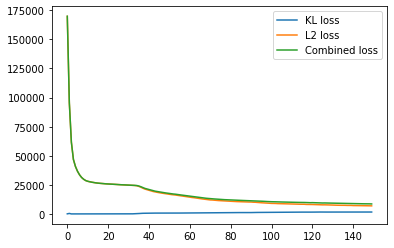

In [12]:
import matplotlib.pyplot as plt
plt.plot(losses["loss1"], label="KL loss")
plt.plot(losses["loss2"], label="L2 loss")
plt.plot(losses["loss"], label="Combined loss")
plt.legend()

plt.show

In [13]:
# safe / load state dict

torch.save(V_model.encoder.state_dict(), "Encoder.pth")
torch.save(V_model.decoder.state_dict(), "Decoder.pth")

In [7]:
V_model.encoder.load_state_dict(torch.load("VAE_models/Encoder.pth"))
#V_model.decoder.load_state_dict(torch.load("VAE_models/Decoder.pth"))

<All keys matched successfully>

# Observe training results

State number: 258


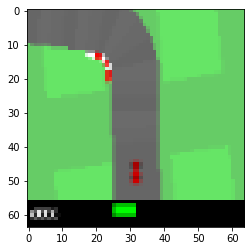

In [16]:
len(samples["states"])
nr = np.random.randint(len(samples["states"]))
print("State number:", nr)
example_image = samples["states"][nr]
# select example image
plt.imshow(example_image.squeeze().reshape(64,64,3))

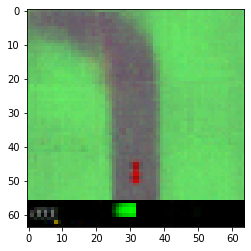

In [17]:
# view reconstructed image
reconstr, _ = V_model.forward(example_image.to(device))
plt.imshow(reconstr.detach().cpu().numpy().reshape(64,64,3))

# M-Model

In [8]:
class MModel(nn.Module):
    def __init__(self, action_size, latent_size=32, hidden_size=256, batch_size=6, n_gaussians=5, rnn_type="LSTM"):
        super(MModel, self).__init__()
        
        self.input_shape = action_size+latent_size
        self.action_size = action_size
        self.latent_size = latent_size
        self.n_gaussians = n_gaussians
        self.batch_size = batch_size
        self.sequence_length = 10
        
        if rnn_type == "LSTM":
            self.rnn_layer = nn.LSTM(self.input_shape, hidden_size, batch_first=True)
        elif rnn_type == "GRU":
            self.rnn_layer = nn.GRU(self.input_shape, hidden_size, batch_first=True)
            
        self.gmm_layer = nn.Linear(hidden_size,  (2 * latent_size + 1) * n_gaussians + 2) #(2 * latent_size + 1) * n_gaussians + 2
        #self.mu_layer = nn.Linear(hidden_size,  latent_size * n_gaussians)
        #self.sig_layer = nn.Linear(hidden_size, latent_size * n_gaussians)
        
        
    def forward(self, latent_vector: torch.Tensor, action:torch.Tensor, hidden_state=None)-> torch.Tensor:
        """ Simple forward pass with the RNN """
        
        assert latent_vector.shape == (latent_vector.shape[0], latent_vector.shape[1], self.latent_size), "Latent vector has the wrong shape!"
        assert action.shape == (action.shape[0], action.shape[1], self.action_size), "Action batch has the wrong shape!"
        
        input_tensor = torch.cat((latent_vector, action),dim=-1)
        assert input_tensor.shape == (action.shape[0], action.shape[1], self.input_shape), "input_tensor has wrong shape!"
        
        output, hidden_state = self.rnn_layer(input_tensor, hidden_state)
        
        (pi, mu, sigma) = self.get_gauss_coeffs(output)
        return (pi, mu, sigma), hidden_state
    
    
    def get_gauss_coeffs(self, y:torch.Tensor):
        
        batch_size = y.shape[0]
        sequence_length = y.shape[1]

        
        gmm = self.gmm_layer(y)

        stride = self.n_gaussians * self.latent_size

        mu = gmm[:, :, :stride]
        mu = mu.view(batch_size, sequence_length, self.n_gaussians, self.latent_size)

        sigma = gmm[:, :, stride:2 * stride]
        sigma = sigma.view(batch_size, sequence_length, self.n_gaussians, self.latent_size)
        sigma = torch.exp(sigma)

        pi = gmm[:, :, 2 * stride: 2 * stride + self.n_gaussians]
        pi = pi.view(batch_size, sequence_length, self.n_gaussians)
        logpi = F.log_softmax(pi, dim=-1)

        rs = gmm[:, :, -2] # needed later if start dreaming

        ds = gmm[:, :, -1] # needed later if start dreaming
        
        
        return logpi, mu, sigma
    
    def predict_next_z(self,latent_vector: torch.Tensor, action:torch.Tensor, tau: float, hidden_state=None)-> torch.Tensor:
        """ Predicts the next Latent Vector Z """
        values, hidden_state = self.forward(latent_vector, action, hidden_state)
        mu, sigma = values[1], values[2]
        
        dist = Normal(mu, sigma*tau)
        z_ = dist.sample().mean(2)
        
        return z_, hidden_state
        
# M-Model loss calculation
def mdn_loss_fn(y, logpi, mu, sigma):

    dist = Normal(mu, sigma)

    log_probs = dist.log_prob(y)
    log_probs = logpi + torch.sum(log_probs, dim=-1)
    max_log_probs = torch.max(log_probs, dim=-1, keepdim=True)[0]
    log_probs = log_probs - max_log_probs

    probs = torch.exp(log_probs)
    sum_probs = torch.sum(probs, dim=-1)

    log_prob = max_log_probs.squeeze() + torch.log(sum_probs)
    
    
    
    return -log_prob.mean()


def criterion(y, pi, mu, sigma):
    y = y.unsqueeze(-2) # MIGHT NOT BE NEEDED!!! 
    return mdn_loss_fn(y, pi, mu, sigma)

In [9]:
action_size = env.action_space.shape[0]
m_model = MModel(action_size=action_size).to(device)

In [52]:
M_optimizer = optim.RMSprop(params=m_model.parameters(), lr=1e-3, alpha=.9)
#M_optimizer = optim.Adam(params=m_model.parameters(), lr=1e-4)#, alpha=.9)


In [53]:
m_actions = samples["actions"]
m_actions = torch.from_numpy(np.array(m_actions))
m_states = torch.cat(samples["states"], dim=0)
m_next_states = torch.cat(samples["next_states"], dim=0)

seq_length = 10 
batch_size = 16
sequence_samples = {"states": [],
                    "actions": [],
                    "next_states": []}


samples_ = {"states": m_states,
            "actions": m_actions,
            "next_states": m_next_states}

for key, elements in samples_.items():
    sequences = []
    #print(len(elements))
    for i in range(len(elements)-seq_length):
        sequences.append(elements[i:i+seq_length].unsqueeze(0))

    sequence_samples[key] = torch.cat(sequences)
dataset = TensorDataset(sequence_samples["states"], sequence_samples["actions"], sequence_samples["next_states"])
m_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)

In [54]:
def encode_batch_sequence(batch, batch_size=16, sequence_length=10, latent_size=32):
    encoded = []
    for sequence in batch:
        for sample in sequence:
            encoded.append(V_model.encode_state(sample.unsqueeze(0).to(device)))
    return torch.cat(encoded).reshape(batch_size, sequence_length, latent_size)

In [56]:
# Train M-Model:
V_model.encoder.eval()
Episodes = 50
losses = []
for ep in range(Episodes):
    ep_losses = []
    for (states, actions, next_states) in m_dataloader:
        
        
        with torch.no_grad():
            z = encode_batch_sequence(states)
            targets = encode_batch_sequence(next_states)
        
        (pi, mu, sigma), _ = m_model(latent_vector=z,
                                   action=actions.to(device),
                                   hidden_state=None)

        
        M_optimizer.zero_grad()
        loss = criterion(targets, pi, mu, sigma)
        loss.backward()
        M_optimizer.step()
        ep_losses.append(loss.detach().cpu().numpy())
        
    losses.append(np.mean(ep_losses))    
    print("\rEpisode: {} | Loss: {}".format(ep, np.mean(ep_losses)), end="", flush=True)
    if ep % 25 == 0:
        print("\rEpisode: {} | Loss: {}".format(ep, np.mean(ep_losses)))
        

Episode: 0 | Loss: 43.618778228759766
Episode: 25 | Loss: 40.796207427978516
Episode: 49 | Loss: 40.412975311279384

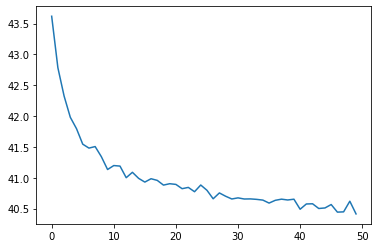

In [57]:
plt.plot(losses)

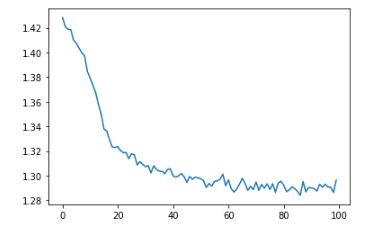

In [58]:
# safe / load state dict

torch.save(m_model.state_dict(), "M-Model.pth")

In [10]:
m_model.load_state_dict(torch.load("M-Model.pth"))

<All keys matched successfully>

In [61]:
del(m_dataloader)

# C-Model

In [11]:
class C_Model(nn.Module):
    def __init__(self, action_size, hidden_size=256, latent_size=32, device="cpu"):
        super(C_Model, self).__init__()
        
        self.device = device
        self.action_size = action_size
        
        self.layer_1 = nn.Linear(latent_size+(2*256), hidden_size)
        self.layer_2 = nn.Linear(hidden_size, hidden_size)
        self.layer_3 = nn.Linear(hidden_size, action_size)
        
        
    def forward(self, latent_vector:torch.Tensor, hidden_state:torch.Tensor)-> torch.Tensor:
        """  """
        input_ = torch.cat((latent_vector, hidden_state), dim=1)
        x = torch.relu(self.layer_1(input_))
        x = torch.relu(self.layer_2(x)) 
        x = torch.tanh(self.layer_3(x)) 
        # add var to prediction as well
        return x
    
    def get_action(self, latent_vector:torch.Tensor, hidden_state:torch.Tensor)-> torch.Tensor:
        """  """
        #print(latent_vector.shape)
        #print(hidden_state[0].shape)
        #print(torch.cat(hidden_state, dim=-1).squeeze(0).shape)
        mu = self.forward(latent_vector, torch.cat(hidden_state, dim=-1).squeeze(0))
        dist = Normal(mu, torch.ones(1).to(self.device)*0.2)
        action = dist.sample()
        log_prob = dist.log_prob(action)
        
        return action, log_prob
    

def calc_discounted_rewards(rewards, final_state, gamma = 0.95):
    R = 0
    discounted = []
  
    for idx in reversed(range(len(rewards))):
        R = rewards[idx]+R*gamma *final_state[idx]
        discounted.insert(0,R)
    return discounted
    
def update_cmodel(log_pis:torch.Tensor, rewards:torch.Tensor)-> np.array:
    """ Updating the C-Model in a PG-Style """
    assert log_pis.shape[0] == rewards.shape[0]
    
    c_model_optim.zero_grad()
    # Normalize.
    mean = torch.mean(rewards)
    std = torch.std(rewards)
    rewards = (rewards - mean) / (std)
    
    loss = (-log_pis*(rewards-rewards.mean())).sum()
    loss.backward()
    c_model_optim.step()
    return loss.detach().cpu().numpy()

In [12]:
action_size = env.action_space.shape[0]
c_model = C_Model(action_size, device=device).to(device)

In [13]:
c_model_optim = optim.Adam(params=c_model.parameters(), lr=0.0001)

## Train without M-Model

Train the C-Model in Policy Gradient Style without the M-Model!

In [11]:
episodes = 650
c_model_rewards = []
high_action = env.action_space.high
low_action = env.action_space.low
for ep in range(episodes):
    state = env.reset()
    done = False
    episode_rewards = 0
    
    reward_batch = []
    dones_batch = []
    log_prob_batch = []
    
    while True:
        
        # run with sampled latent vector
        #latent_vector_z = V_model.encode_state(state.to(device))
        #zero_hidden = torch.zeros_like(latent_vector_z).to(device)
        
        # run with mu and sig from encoder
        latent_vector_z, zero_hidden = V_model.encoder(state.to(device))
        
        action, log_prob = c_model.get_action(latent_vector_z, zero_hidden)
        
        action = np.asarray(np.clip(action.detach().cpu().numpy(), a_min=low_action, a_max=high_action), dtype=np.float32).squeeze()

        state, reward, done, _ = env.step(action)
        
        reward_batch.append(reward)
        dones_batch.append(1-int(done))
        log_prob_batch.append(log_prob)
        
        episode_rewards += reward
        
        if done:
            break
            
    rewards = calc_discounted_rewards(reward_batch, dones_batch)

    loss = update_cmodel(torch.cat(log_prob_batch, dim=0),
                         torch.FloatTensor(rewards).unsqueeze(-1).to(device))
    
    del(reward_batch)
    del(dones_batch)
    del(log_prob_batch)
    c_model_rewards.append(episode_rewards)    
            
    print("\rEpoch: {} | Reward: {:.2f} | Loss: {:.2f}".format(ep, episode_rewards, loss), end="", flush=True)
    if ep % 10 == 0:
        print("\rEpoch: {} | Reward: {:.2f} | Loss: {:.2f}".format(ep, episode_rewards, loss))
    env.close()
    
        

Track generation: 1215..1523 -> 308-tiles track
Epoch: 0 | Reward: -34.85 | Loss: 5.61
Track generation: 1060..1329 -> 269-tiles track
Epoch: 1 | Reward: -6.72 | Loss: -9.10Track generation: 963..1214 -> 251-tiles track
Epoch: 2 | Reward: -56.00 | Loss: 2.71Track generation: 1131..1418 -> 287-tiles track
Epoch: 3 | Reward: -23.08 | Loss: -4.35Track generation: 1011..1271 -> 260-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1028..1289 -> 261-tiles track
Epoch: 4 | Reward: -7.69 | Loss: -6.50Track generation: 1040..1310 -> 270-tiles track
Epoch: 5 | Reward: -14.50 | Loss: 1.21Track generation: 1081..1364 -> 283-tiles track
Epoch: 6 | Reward: -25.53 | Loss: 7.16Track generation: 1184..1484 -> 300-tiles track
Epoch: 7 | Reward: -23.08 | Loss: -17.64Track generation: 1078..1351 -> 273-tiles track
Epoch: 8 | Reward: -19.12 | Loss: 18.93Track generation: 1111..1393 -> 282-tiles track
Epoch: 9 | Reward: -32.38 | Loss: -8.92Track g

Epoch: 80 | Reward: 123.88 | Loss: -3.92
Track generation: 1180..1485 -> 305-tiles track
Epoch: 81 | Reward: 123.68 | Loss: 2.45Track generation: 1229..1540 -> 311-tiles track
Epoch: 82 | Reward: -32.26 | Loss: 11.72Track generation: 1432..1795 -> 363-tiles track
Epoch: 83 | Reward: -30.94 | Loss: 7.13Track generation: 1099..1385 -> 286-tiles track
Epoch: 84 | Reward: -28.20 | Loss: -3.54Track generation: 1120..1404 -> 284-tiles track
Epoch: 85 | Reward: 44.88 | Loss: -9.39Track generation: 1039..1303 -> 264-tiles track
Epoch: 86 | Reward: 40.68 | Loss: 5.21Track generation: 1161..1455 -> 294-tiles track
Epoch: 87 | Reward: -39.22 | Loss: 0.90Track generation: 1107..1388 -> 281-tiles track
Epoch: 88 | Reward: -133.49 | Loss: 11.14Track generation: 1085..1365 -> 280-tiles track
Epoch: 89 | Reward: -50.38 | Loss: -8.78Track generation: 1215..1523 -> 308-tiles track
Epoch: 90 | Reward: 0.98 | Loss: 21.53
Track generation: 1159..1453 -> 294-tiles track
Epoch: 91 | Reward: 60.41 | Loss: -8.

Epoch: 167 | Reward: -44.00 | Loss: 1.09Track generation: 1272..1594 -> 322-tiles track
Epoch: 168 | Reward: 183.49 | Loss: 2.97Track generation: 1193..1501 -> 308-tiles track
Epoch: 169 | Reward: 170.36 | Loss: -40.94Track generation: 1124..1409 -> 285-tiles track
Epoch: 170 | Reward: 47.89 | Loss: -26.42
Track generation: 1203..1513 -> 310-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 912..1152 -> 240-tiles track
Epoch: 171 | Reward: 151.05 | Loss: -27.17Track generation: 1280..1604 -> 324-tiles track
Epoch: 172 | Reward: 166.25 | Loss: -27.51Track generation: 1136..1424 -> 288-tiles track
Epoch: 173 | Reward: 60.28 | Loss: -9.74Track generation: 1000..1254 -> 254-tiles track
Epoch: 174 | Reward: 113.44 | Loss: -15.46Track generation: 1210..1516 -> 306-tiles track
Epoch: 175 | Reward: 57.38 | Loss: -2.83Track generation: 1097..1375 -> 278-tiles track
Epoch: 176 | Reward: 87.73 | Loss: 23.71Track generation: 1184..1484 ->

Epoch: 251 | Reward: -35.81 | Loss: 5.40Track generation: 1283..1608 -> 325-tiles track
Epoch: 252 | Reward: 11.11 | Loss: -6.24Track generation: 1048..1324 -> 276-tiles track
Epoch: 253 | Reward: 369.09 | Loss: 0.92Track generation: 1172..1476 -> 304-tiles track
Epoch: 254 | Reward: 71.62 | Loss: -31.56Track generation: 1065..1342 -> 277-tiles track
Epoch: 255 | Reward: -23.91 | Loss: -23.36Track generation: 1083..1358 -> 275-tiles track
Epoch: 256 | Reward: 129.93 | Loss: -21.15Track generation: 1310..1641 -> 331-tiles track
Epoch: 257 | Reward: 42.42 | Loss: -8.12Track generation: 1223..1533 -> 310-tiles track
Epoch: 258 | Reward: 145.95 | Loss: -29.28Track generation: 1047..1319 -> 272-tiles track
Epoch: 259 | Reward: 169.37 | Loss: 6.00Track generation: 1031..1293 -> 262-tiles track
Epoch: 260 | Reward: 106.90 | Loss: -30.59
Track generation: 1095..1379 -> 284-tiles track
Epoch: 261 | Reward: 246.29 | Loss: -34.56Track generation: 1186..1487 -> 301-tiles track
Epoch: 262 | Reward:

Epoch: 331 | Reward: 60.54 | Loss: -8.00Track generation: 1216..1524 -> 308-tiles track
Epoch: 332 | Reward: 49.84 | Loss: 12.00Track generation: 1161..1455 -> 294-tiles track
Epoch: 333 | Reward: 132.08 | Loss: -12.41Track generation: 1171..1477 -> 306-tiles track
Epoch: 334 | Reward: 145.90 | Loss: 4.30Track generation: 1079..1362 -> 283-tiles track
Epoch: 335 | Reward: 11.07 | Loss: -1.36Track generation: 1095..1373 -> 278-tiles track
Epoch: 336 | Reward: 40.79 | Loss: -18.24Track generation: 1085..1360 -> 275-tiles track
Epoch: 337 | Reward: 9.49 | Loss: 13.54Track generation: 1012..1269 -> 257-tiles track
Epoch: 338 | Reward: 110.94 | Loss: 17.11Track generation: 1220..1529 -> 309-tiles track
Epoch: 339 | Reward: 107.79 | Loss: 14.93Track generation: 1316..1654 -> 338-tiles track
Epoch: 340 | Reward: 83.98 | Loss: -11.49
Track generation: 1178..1477 -> 299-tiles track
Epoch: 341 | Reward: 10.74 | Loss: -10.22Track generation: 1043..1308 -> 265-tiles track
Epoch: 342 | Reward: 40.1

Epoch: 418 | Reward: -60.17 | Loss: 20.57Track generation: 1100..1381 -> 281-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1292..1619 -> 327-tiles track
Epoch: 419 | Reward: 215.95 | Loss: 27.51Track generation: 1130..1416 -> 286-tiles track
Epoch: 420 | Reward: 78.95 | Loss: 28.35
Track generation: 1356..1699 -> 343-tiles track
Epoch: 421 | Reward: 63.74 | Loss: -19.22Track generation: 1144..1434 -> 290-tiles track
Epoch: 422 | Reward: 117.99 | Loss: 6.28Track generation: 1150..1441 -> 291-tiles track
Epoch: 423 | Reward: -3.67 | Loss: 10.60Track generation: 1356..1700 -> 344-tiles track
Epoch: 424 | Reward: 147.81 | Loss: -40.75Track generation: 1215..1523 -> 308-tiles track
Epoch: 425 | Reward: -15.31 | Loss: -32.71Track generation: 1251..1568 -> 317-tiles track
Epoch: 426 | Reward: 1.27 | Loss: 23.39Track generation: 1204..1509 -> 305-tiles track
Epoch: 427 | Reward: 17.58 | Loss: 0.53Track generation: 1137..1426 -> 28

Epoch: 502 | Reward: -1.75 | Loss: 10.67Track generation: 1001..1268 -> 267-tiles track
Epoch: 503 | Reward: 54.14 | Loss: 19.47Track generation: 1063..1339 -> 276-tiles track
Epoch: 504 | Reward: 220.00 | Loss: 18.03Track generation: 1231..1543 -> 312-tiles track
Epoch: 505 | Reward: 208.68 | Loss: -8.40Track generation: 1207..1513 -> 306-tiles track
Epoch: 506 | Reward: 11.48 | Loss: -19.06Track generation: 1246..1561 -> 315-tiles track
Epoch: 507 | Reward: 87.90 | Loss: -27.97Track generation: 1236..1549 -> 313-tiles track
Epoch: 508 | Reward: 28.21 | Loss: 13.89Track generation: 1068..1339 -> 271-tiles track
Epoch: 509 | Reward: 118.52 | Loss: -26.70Track generation: 1061..1336 -> 275-tiles track
Epoch: 510 | Reward: 2.19 | Loss: -21.72
Track generation: 1404..1759 -> 355-tiles track
Epoch: 511 | Reward: 117.51 | Loss: -25.85Track generation: 1235..1548 -> 313-tiles track
Epoch: 512 | Reward: -39.10 | Loss: 1.94Track generation: 1160..1459 -> 299-tiles track
Epoch: 513 | Reward: 84

Epoch: 662 | Reward: 23.72 | Loss: -0.52Track generation: 1208..1514 -> 306-tiles track
Epoch: 663 | Reward: 103.28 | Loss: -29.01Track generation: 1481..1855 -> 374-tiles track
Epoch: 664 | Reward: 91.17 | Loss: -6.92Track generation: 1191..1493 -> 302-tiles track
Epoch: 665 | Reward: 122.59 | Loss: -18.38Track generation: 1176..1480 -> 304-tiles track
Epoch: 666 | Reward: 45.21 | Loss: -3.01Track generation: 1096..1374 -> 278-tiles track
Epoch: 667 | Reward: -49.26 | Loss: 2.34Track generation: 1140..1429 -> 289-tiles track
Epoch: 668 | Reward: 281.94 | Loss: -38.03Track generation: 1227..1538 -> 311-tiles track
Epoch: 669 | Reward: -37.32 | Loss: 9.68Track generation: 1189..1490 -> 301-tiles track
Epoch: 670 | Reward: 176.67 | Loss: 14.41
Track generation: 1088..1364 -> 276-tiles track
Epoch: 671 | Reward: 60.00 | Loss: -16.92Track generation: 1134..1421 -> 287-tiles track
Epoch: 672 | Reward: 162.24 | Loss: -12.71Track generation: 1103..1382 -> 279-tiles track
Epoch: 673 | Reward: 

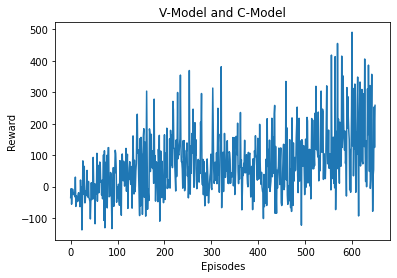

In [16]:
plt.plot(c_model_rewards[:650])
plt.title("V-Model and C-Model")
plt.xlabel("Episodes")
plt.ylabel("Reward")
plt.savefig("V+C-Training.jpg")

# Train with V, M 

In [14]:
episodes = 600
combined_model_rewards = []
high_action = env.action_space.high
low_action = env.action_space.low
for ep in range(episodes):
    state = env.reset()
    done = False
    episode_rewards = 0
    
    reward_batch = []
    dones_batch = []
    log_prob_batch = []
    hidden_state = (torch.zeros((1, 1, 256)).to(device),torch.zeros((1, 1,  256)).to(device))
    while True:
        
        with torch.no_grad():
            latent_vector_z = V_model.encode_state(state.to(device))
        
        action, log_prob = c_model.get_action(latent_vector_z, hidden_state)
        action_ = np.asarray(np.clip(action.detach().cpu().numpy(), a_min=low_action, a_max=high_action), dtype=np.float32).squeeze()
        state, reward, done, _ = env.step(action_)

        with torch.no_grad():
            
            _, hidden_state = m_model.predict_next_z(latent_vector_z.unsqueeze(0), 
                                                     torch.from_numpy(action_).unsqueeze(0).unsqueeze(0).float().to(device), 
                                                     tau=1.1, 
                                                     hidden_state=hidden_state)
        
        reward_batch.append(reward)
        dones_batch.append(1-int(done))
        log_prob_batch.append(log_prob)
        
        
        
        
        episode_rewards += reward
        
        if done:
            break
            
    rewards = calc_discounted_rewards(reward_batch, dones_batch)

    loss = update_cmodel(torch.cat(log_prob_batch, dim=0),
                         torch.FloatTensor(rewards).unsqueeze(-1).to(device))
    
    del(reward_batch)
    del(dones_batch)
    del(log_prob_batch)
    combined_model_rewards.append(episode_rewards)    
            
    print("\rEpoch: {} | Reward: {:.2f} | Loss: {:.2f}".format(ep, episode_rewards, loss), end="", flush=True)
    if ep % 10 == 0:
        print("\rEpoch: {} | Reward: {:.2f} | Loss: {:.2f}".format(ep, episode_rewards, loss))
    env.close()

Track generation: 1090..1367 -> 277-tiles track
Epoch: 0 | Reward: -124.52 | Loss: -13.38
Track generation: 1223..1532 -> 309-tiles track
Epoch: 1 | Reward: -31.82 | Loss: -43.96Track generation: 1122..1407 -> 285-tiles track
Epoch: 2 | Reward: -64.79 | Loss: 34.94Track generation: 1178..1484 -> 306-tiles track
Epoch: 3 | Reward: -54.10 | Loss: -18.98Track generation: 1155..1448 -> 293-tiles track
Epoch: 4 | Reward: -34.93 | Loss: -23.81Track generation: 1115..1404 -> 289-tiles track
Epoch: 5 | Reward: -47.92 | Loss: -32.13Track generation: 1028..1289 -> 261-tiles track
Epoch: 6 | Reward: -124.20 | Loss: -21.19Track generation: 1208..1514 -> 306-tiles track
Epoch: 7 | Reward: -140.93 | Loss: -25.62Track generation: 1299..1628 -> 329-tiles track
Epoch: 8 | Reward: -174.01 | Loss: 6.96Track generation: 1272..1594 -> 322-tiles track
Epoch: 9 | Reward: -43.93 | Loss: -25.83Track generation: 1142..1431 -> 289-tiles track
Epoch: 10 | Reward: -170.59 | Loss: -8.15
Track generation: 1054..1325

Epoch: 86 | Reward: -60.43 | Loss: 25.50Track generation: 1119..1403 -> 284-tiles track
Epoch: 87 | Reward: -64.66 | Loss: 2.31Track generation: 1037..1300 -> 263-tiles track
Epoch: 88 | Reward: -61.83 | Loss: -9.58Track generation: 1213..1520 -> 307-tiles track
Epoch: 89 | Reward: -64.05 | Loss: -10.49Track generation: 1211..1518 -> 307-tiles track
Epoch: 90 | Reward: -73.86 | Loss: 16.20
Track generation: 1060..1329 -> 269-tiles track
Epoch: 91 | Reward: -62.69 | Loss: -1.57Track generation: 1044..1309 -> 265-tiles track
Epoch: 92 | Reward: -65.91 | Loss: -19.97Track generation: 1055..1323 -> 268-tiles track
Epoch: 93 | Reward: -62.55 | Loss: 22.12Track generation: 1032..1294 -> 262-tiles track
Epoch: 94 | Reward: -69.35 | Loss: -21.69Track generation: 1176..1474 -> 298-tiles track
Epoch: 95 | Reward: -66.33 | Loss: -8.45Track generation: 1095..1373 -> 278-tiles track
Epoch: 96 | Reward: -49.46 | Loss: 12.44Track generation: 1028..1289 -> 261-tiles track
Epoch: 97 | Reward: -65.38 | 

Epoch: 171 | Reward: -26.74 | Loss: -11.92Track generation: 1088..1364 -> 276-tiles track
Epoch: 172 | Reward: -23.64 | Loss: -26.08Track generation: 911..1148 -> 237-tiles track
Epoch: 173 | Reward: 18.64 | Loss: 11.20Track generation: 1207..1513 -> 306-tiles track
Epoch: 174 | Reward: -24.59 | Loss: -5.74Track generation: 1411..1768 -> 357-tiles track
Epoch: 175 | Reward: -55.06 | Loss: -6.18Track generation: 1264..1584 -> 320-tiles track
Epoch: 176 | Reward: -62.38 | Loss: 5.68Track generation: 910..1147 -> 237-tiles track
Epoch: 177 | Reward: -6.78 | Loss: -16.77Track generation: 1103..1383 -> 280-tiles track
Epoch: 178 | Reward: -10.39 | Loss: -20.00Track generation: 976..1229 -> 253-tiles track
Epoch: 179 | Reward: -16.67 | Loss: 14.59Track generation: 1190..1490 -> 300-tiles track
Epoch: 180 | Reward: -39.80 | Loss: -0.22
Track generation: 1229..1540 -> 311-tiles track
Epoch: 181 | Reward: -41.94 | Loss: -15.83Track generation: 1141..1430 -> 289-tiles track
Epoch: 182 | Reward: 

Epoch: 260 | Reward: -66.10 | Loss: 32.29
Track generation: 1193..1503 -> 310-tiles track
Epoch: 261 | Reward: -54.69 | Loss: -16.00Track generation: 1057..1331 -> 274-tiles track
Epoch: 262 | Reward: -58.79 | Loss: 0.38Track generation: 991..1247 -> 256-tiles track
Epoch: 263 | Reward: -25.49 | Loss: -18.62Track generation: 1155..1448 -> 293-tiles track
Epoch: 264 | Reward: -31.51 | Loss: 6.54Track generation: 1219..1537 -> 318-tiles track
Epoch: 265 | Reward: -40.06 | Loss: 1.91Track generation: 1268..1590 -> 322-tiles track
Epoch: 266 | Reward: -31.46 | Loss: -11.33Track generation: 1194..1496 -> 302-tiles track
Epoch: 267 | Reward: -40.20 | Loss: -30.23Track generation: 1134..1421 -> 287-tiles track
Epoch: 268 | Reward: -30.07 | Loss: 28.92Track generation: 1050..1321 -> 271-tiles track
Epoch: 269 | Reward: -22.22 | Loss: 0.63Track generation: 1164..1459 -> 295-tiles track
Epoch: 270 | Reward: -38.78 | Loss: 10.18
Track generation: 1244..1559 -> 315-tiles track
Epoch: 271 | Reward:

Epoch: 344 | Reward: -0.36 | Loss: -12.50Track generation: 1055..1323 -> 268-tiles track
Epoch: 345 | Reward: 105.99 | Loss: 27.32Track generation: 1160..1454 -> 294-tiles track
Epoch: 346 | Reward: 33.11 | Loss: -30.76Track generation: 1081..1364 -> 283-tiles track
Epoch: 347 | Reward: 2.84 | Loss: 6.18Track generation: 1115..1398 -> 283-tiles track
Epoch: 348 | Reward: -32.62 | Loss: -28.79Track generation: 1351..1693 -> 342-tiles track
Epoch: 349 | Reward: -32.55 | Loss: 10.88Track generation: 1124..1419 -> 295-tiles track
Epoch: 350 | Reward: -8.16 | Loss: -9.01
Track generation: 1250..1567 -> 317-tiles track
Epoch: 351 | Reward: 13.92 | Loss: -9.83Track generation: 1035..1298 -> 263-tiles track
Epoch: 352 | Reward: 6.87 | Loss: 2.40Track generation: 1183..1481 -> 298-tiles track
Epoch: 353 | Reward: -36.03 | Loss: -14.23Track generation: 1108..1392 -> 284-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1087..1363 -> 276

Epoch: 427 | Reward: 6.38 | Loss: -11.73Track generation: 1283..1608 -> 325-tiles track
Epoch: 428 | Reward: -47.53 | Loss: 7.24Track generation: 996..1254 -> 258-tiles track
Epoch: 429 | Reward: -26.07 | Loss: -23.67Track generation: 1277..1600 -> 323-tiles track
Epoch: 430 | Reward: -16.15 | Loss: -22.45
Track generation: 1189..1490 -> 301-tiles track
Epoch: 431 | Reward: 46.67 | Loss: 22.44Track generation: 1085..1360 -> 275-tiles track
Epoch: 432 | Reward: 38.69 | Loss: -16.79Track generation: 1187..1488 -> 301-tiles track
Epoch: 433 | Reward: 40.00 | Loss: 12.42Track generation: 1087..1369 -> 282-tiles track
Epoch: 434 | Reward: 45.91 | Loss: -3.70Track generation: 1015..1278 -> 263-tiles track
Epoch: 435 | Reward: 45.04 | Loss: 22.70Track generation: 1145..1435 -> 290-tiles track
Epoch: 436 | Reward: 62.63 | Loss: 13.77Track generation: 1152..1444 -> 292-tiles track
Epoch: 437 | Reward: 154.30 | Loss: -31.94Track generation: 1260..1579 -> 319-tiles track
Epoch: 438 | Reward: -123

Epoch: 513 | Reward: 18.32 | Loss: 17.12Track generation: 1188..1489 -> 301-tiles track
Epoch: 514 | Reward: 113.33 | Loss: -17.44Track generation: 1060..1329 -> 269-tiles track
Epoch: 515 | Reward: 8.21 | Loss: 9.30Track generation: 1056..1324 -> 268-tiles track
Epoch: 516 | Reward: 15.54 | Loss: -32.03Track generation: 1300..1638 -> 338-tiles track
Epoch: 517 | Reward: 48.37 | Loss: 15.15Track generation: 1043..1308 -> 265-tiles track
Epoch: 518 | Reward: 119.70 | Loss: -22.69Track generation: 1001..1260 -> 259-tiles track
Epoch: 519 | Reward: 39.53 | Loss: 8.26Track generation: 972..1224 -> 252-tiles track
Epoch: 520 | Reward: 107.17 | Loss: -0.96
Track generation: 1065..1344 -> 279-tiles track
Epoch: 521 | Reward: 79.86 | Loss: -2.16Track generation: 1163..1458 -> 295-tiles track
Epoch: 522 | Reward: 8.84 | Loss: -20.44Track generation: 1191..1493 -> 302-tiles track
Epoch: 523 | Reward: 2.99 | Loss: 12.37Track generation: 1058..1335 -> 277-tiles track
Epoch: 524 | Reward: 102.90 | 

Epoch: 598 | Reward: -0.71 | Loss: 9.60Track generation: 1179..1478 -> 299-tiles track
Epoch: 599 | Reward: 155.03 | Loss: 9.06

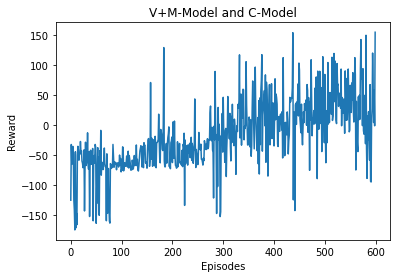

In [15]:
plt.plot(combined_model_rewards)
plt.title("V+M-Model and C-Model")
plt.xlabel("Episodes")
plt.ylabel("Reward")
plt.savefig("V+M+C-Training.jpg")

In [69]:
env.close()